# Refining a grid

This example refines zero point and vectors a, b  based on previously known approximate values
for main lattice and superlattice for each frame. The analysis is not based on 3D crystallographic 
information of the sample, but purely on the peak positions in the detector plane. In the following, 
"lattice" refers to the geometric arrangement of the peaks, not the crystal lattice of the sample.

The correlation uses the background substraction kernel from the `peak_selector.ipynb` example,
which means that the maximum correlation values are the background-substracted peak intensities. Based on the correlation result and peak positions, detailed maps of various parameters can be created.

Please note that the underlying code is under active development and might change in the future!

Sample data courtesy of Ian MacLaren <Ian.MacLaren@glasgow.ac.uk> and
Shane McCartan <s.mccartan.1@research.gla.ac.uk>, University of Glasgow

Sample preparation: David Hall and Ilkan Calisir

The dataset is from a solid solution ceramic of bismuth ferrite and barium 
titanate (ratio: 75%/25%) doped 3% Ti. Chemical segregation of the bismuth 
ferrite and barium titanate occurs in the formation of the core-shell type 
structure that you can see in the grain (barium titanate-shell, bismuth 
ferrite-core). The grain is orientated along the [110] direction as the 
extra spots that BFO produces at the 1/2 (111) positions are obvious in 
this orientation. Otherwise the diffraction patterns of BFO and BTO are 
too similar to distinguish easily.

## Set up the environment and import libraries

We disable threading in any numerics libraries because we already saturate the CPU with multiprocessing. Additional threads would get in each other's way and slow things down rather than speed them up. The environment variables have to be set as early as possible before any of the libraries are loaded.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
%matplotlib nbagg

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from libertem import api
import libertem.udf.blobfinder as blobfinder
import libertem.analysis.gridmatching as grm

## Create LiberTEM Context
Start a local cluster (default) or connect to a running cluster (TODO: To be implemented).

A warning about port 8787 being already in use can be ignored, that's only for cluster diagnostics.

In [4]:
ctx = api.Context()

## Load file
The parameters depend on the data set type. We can get basic information about the file from the dataset, for example its dimensions.

In [5]:
ds = ctx.load(
    "blo",
    path='C:/Users/weber/Nextcloud/Projects/Open Pixelated STEM framework/Data/3rd-party Datasets/Glasgow/10 um 110.blo',
    tileshape=(1,8,144,144)
)

In [6]:
(y, x, fy, fx) = tuple(ds.shape)

In [7]:
# Parameters for the correlation
parameters = {
    'mask_type': 'background_substraction',
    'radius': 2,
    'radius_outer': 3,
    'padding': 0.5,
}

r = parameters['radius']

# Parameters of the main lattice of the central grain
main_lattice = dict(
    zero=np.array((72.64, 71.38)),
    a=np.array((16.5, 4.33)),
    b=np.array((-3.05, 11.93)),
)

# The superlattice is shifted by a half diagonal step
superlattice_step = (main_lattice['a'] + main_lattice['b']) / 2

super_lattice = dict(
    zero=main_lattice['zero'] + superlattice_step,
    a=main_lattice['a'],
    b=main_lattice['b'],
)


In [8]:
# Run the refinement routines
# This method calculates approximate peak positions based on the given lattice and indices,
# refines the individual positions using Karina's correlation code,
# and the refines the lattice to the refined peak positions and peak qualities.
#
# Since refining many peaks takes a considerable amount of time, we can
# reduce the grid for testing purposes. Refining all peaks in the frame
# currently needs a powerful multicore machine and/or a LiberTEM cluster
# to finish in a convenient time.
(refined_main, main_indices) = blobfinder.run_refine(ctx, ds, **main_lattice, indices=np.mgrid[-2:2, -2:2], corr_params=parameters, match_params={})

In [9]:
(refined_super, super_indices) = blobfinder.run_refine(ctx, ds, **super_lattice, indices=np.mgrid[-2:2, -2:2], corr_params=parameters, match_params={})

In [10]:
# Data extraction and conversion step for plotting.
main_polar_zeros = grm.make_polar(refined_main['zero'].data)
main_polar_aas = grm.make_polar(refined_main['a'].data)
main_polar_bbs = grm.make_polar(refined_main['b'].data)
main_zeros = refined_main['zero'].data
main_aas = refined_main['a'].data
main_bbs = refined_main['b'].data
main_refineds = refined_main['refineds'].data
main_elevations = refined_main['peak_elevations'].data
main_values = refined_main['peak_values'].data
main_selector = refined_main['selector'].data

super_polar_zeros = grm.make_polar(refined_super['zero'].data)
super_polar_aas = grm.make_polar(refined_super['a'].data)
super_polar_bbs = grm.make_polar(refined_super['b'].data)
super_zeros = refined_super['zero'].data
super_aas = refined_super['a'].data
super_bbs = refined_super['b'].data
super_refineds = refined_super['refineds'].data
super_elevations = refined_super['peak_elevations'].data
super_values = refined_super['peak_values'].data
super_selector = refined_super['selector'].data

In [11]:
# Extract some derived values from the lattice parameters
main_angle_difference = (main_polar_aas[:,:,1] - main_polar_bbs[:,:,1])*180/np.pi
main_length_ratio = np.maximum(main_polar_aas[:,:,0] / main_polar_bbs[:,:,0], main_polar_bbs[:,:,0] / main_polar_aas[:,:,0])
main_volume = main_polar_aas[:,:,0] * main_polar_bbs[:,:,0] * np.abs(np.sin(main_polar_aas[:,:,1] - main_polar_bbs[:,:,1]))

# The elevation data creates reliable maps of peak presence since it doesn't only integrate intensity,
# but also increases if the peak is well-defined and has the correct shape.
main_presence = np.array([
    [
        np.sum(main_elevations[i, j][main_selector[i, j]])
        for j in range(x)
    ] for i in range(y)
    
])
# This is the background-substracted peak intensity
main_intensity = np.array([
    [
        np.sum(main_values[i, j][main_selector[i, j]])
        for j in range(x)
    ] for i in range(y)
    
])

# The same for the superlattice
super_angle_difference = (super_polar_aas[:,:,1] - super_polar_bbs[:,:,1])*180/np.pi
super_length_ratio = np.maximum(super_polar_aas[:,:,0] / super_polar_bbs[:,:,0], super_polar_bbs[:,:,0] / super_polar_aas[:,:,0])
super_volume = super_polar_aas[:,:,0] * super_polar_bbs[:,:,0] * np.abs(np.sin(super_polar_aas[:,:,1] - super_polar_bbs[:,:,1]))
super_presence = np.array([
    [
        np.sum(super_elevations[i, j][super_selector[i, j]])
        for j in range(x)
    ] for i in range(y)
    
])
super_intensity = np.array([
    [
        np.sum(super_values[i, j][super_selector[i, j]])
        for j in range(x)
    ] for i in range(y)
    
])

<IPython.core.display.Javascript object>


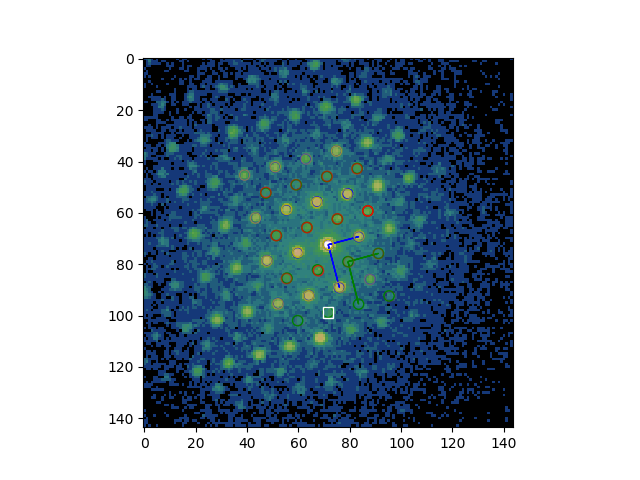

In [12]:
# A sample frame to pick
yy = 57
xx = 76

# Get the frame from the Context
get_sample_frame = ctx.create_pick_analysis(dataset=ds, y=yy, x=xx)
sample_frame = ctx.run(get_sample_frame)

# Plot the sample frame in log scale
fig, axes = plt.subplots()
axes.imshow(np.log(sample_frame[0].raw_data + 1), cmap=cm.gist_earth)

# Normalization values for elevation
# The peak elevation is proportional to intensity and quality of the correlation for a peak.
# It is the slope of the tightest cone that can be fit around the correlation map.
max_main_elevation = np.max(main_elevations[yy, xx])
max_super_elevation = np.max(super_elevations[yy, xx])

# We calculate the "best fit" coordinates for this frame to 
# compare them with the individual correlations to identify outliers
main_calculated = grm.calc_coords(
    zero=main_zeros[yy, xx],
    a=main_aas[yy, xx],
    b=main_bbs[yy, xx],
    indices=main_indices
)

super_calculated = grm.calc_coords(
    zero=super_zeros[yy, xx],
    a=super_aas[yy, xx],
    b=super_bbs[yy, xx],
    indices=super_indices
)

# Plot best fit positions
for p in np.flip(main_calculated):
    axes.add_artist(plt.Circle(p, r, color="b", fill=False))

# Plot best fit base vectors
plt.arrow(*np.flip(main_zeros[yy, xx]), *(np.flip(main_aas[yy, xx])), color='b')
plt.arrow(*np.flip(main_zeros[yy, xx]), *(np.flip(main_bbs[yy, xx])), color='b')

# Extract the peaks that were included in the fit
# The fitting routine rejects outliers and weak peaks
# This example uses default values
# The behavior can be influenced with the match_params parameter of run_refine()
selected_main_refineds = main_refineds[yy, xx][main_selector[yy, xx]]
selected_main_elevations = main_elevations[yy, xx][main_selector[yy, xx]]

# Plot the refined positions, with the alpha channel representing the elevation,
# which has been used as a weight in the fit
for i in range(len(selected_main_refineds)):
    p = np.flip(selected_main_refineds[i])
    a = max(0, selected_main_elevations[i] / max_main_elevation)
    axes.add_artist(plt.Circle(p, r, color="y", fill=False, alpha=a))

# Plot peaks that were excluded
skipped_main_peaks = main_calculated[np.invert(main_selector[yy, xx])]

for i in range(len(skipped_main_peaks)):
    (yyy, xxx) = skipped_main_peaks[i]
    xy = (xxx - r, yyy - r)
    axes.add_artist(plt.Rectangle(xy, 2*r, 2*r, color="r", fill=False))

# The same for the super lattice
for p in np.flip(super_calculated):
    axes.add_artist(plt.Circle(p, r, color="g", fill=False))

plt.arrow(*np.flip(super_zeros[yy, xx]), *(np.flip(super_aas[yy, xx])), color='g')
plt.arrow(*np.flip(super_zeros[yy, xx]), *(np.flip(super_bbs[yy, xx])), color='g')
    
selected_super_refineds = super_refineds[yy, xx][super_selector[yy, xx]]
selected_super_elevations = super_elevations[yy, xx][super_selector[yy, xx]]
    
for i in range(len(selected_super_refineds)):
    p = np.flip(selected_super_refineds[i])
    a = max(0, selected_super_elevations[i] / max_super_elevation)
    axes.add_artist(plt.Circle(p, r, color="r", fill=False, alpha=a))
    
skipped_super_peaks = super_calculated[np.invert(super_selector[yy, xx])]

for i in range(len(skipped_super_peaks)):
    (yyy, xxx) = skipped_super_peaks[i]
    xy = (xxx - r, yyy - r)
    axes.add_artist(plt.Rectangle(xy, 2*r, 2*r, color="w", fill=False))

<IPython.core.display.Javascript object>


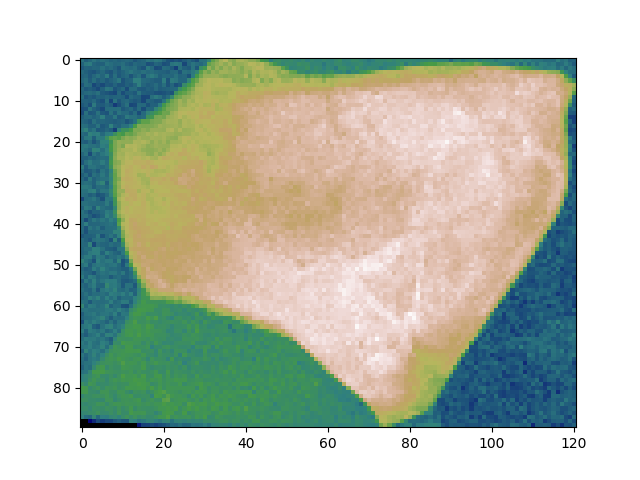

In [13]:
fig, axes = plt.subplots()
axes.imshow(main_intensity, cmap=cm.gist_earth)

<IPython.core.display.Javascript object>


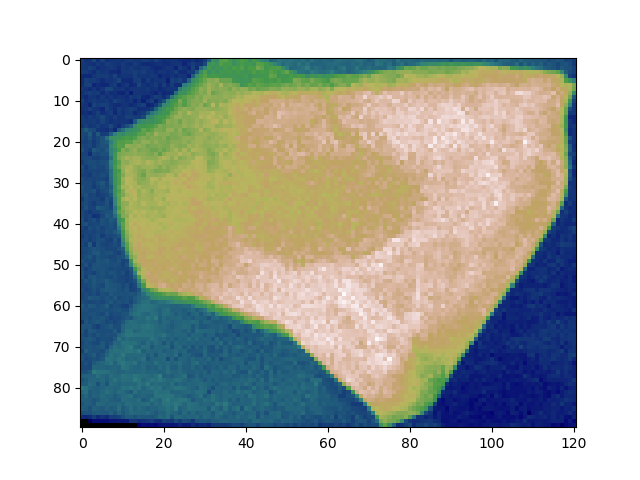

In [14]:
fig, axes = plt.subplots()
axes.imshow(main_presence, cmap=cm.gist_earth)

<IPython.core.display.Javascript object>


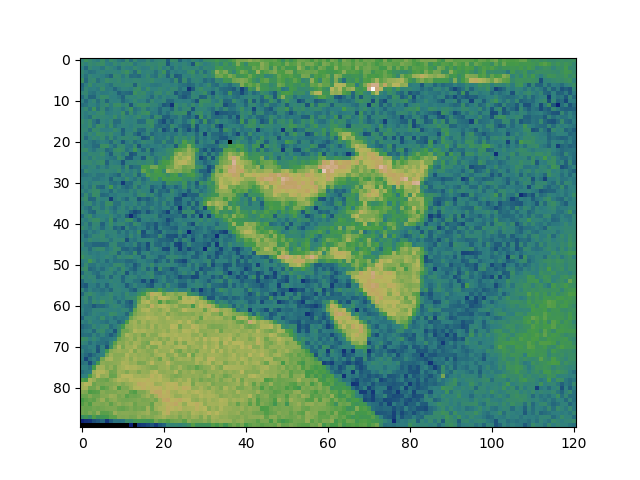

In [15]:
fig, axes = plt.subplots()
axes.imshow(super_intensity, cmap=cm.gist_earth)

<IPython.core.display.Javascript object>


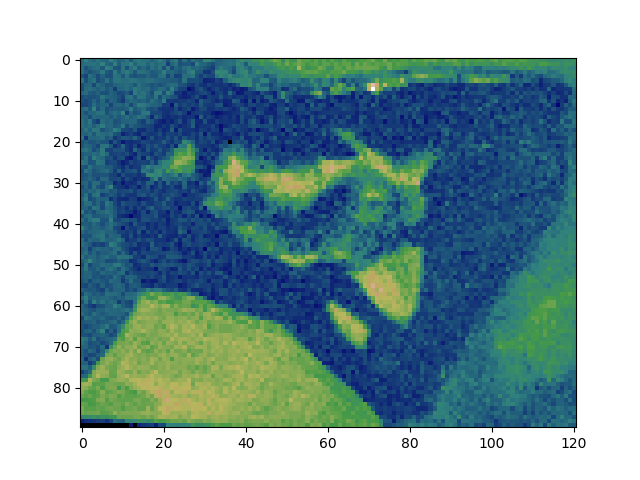

In [16]:
fig, axes = plt.subplots()
# Note how the presence of the superlattice has more contrast than the intensity in the previous plot
axes.imshow(super_presence, cmap=cm.gist_earth)

<IPython.core.display.Javascript object>


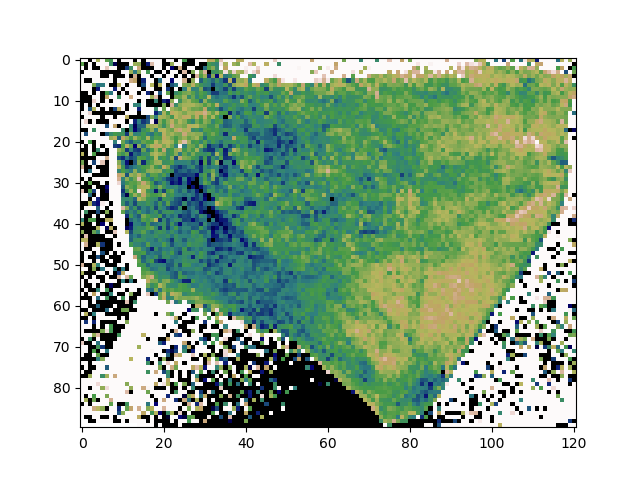

In [17]:
fig, axes = plt.subplots()
axes.imshow(main_length_ratio, cmap=cm.gist_earth, vmin=1.37, vmax=1.42)

<IPython.core.display.Javascript object>


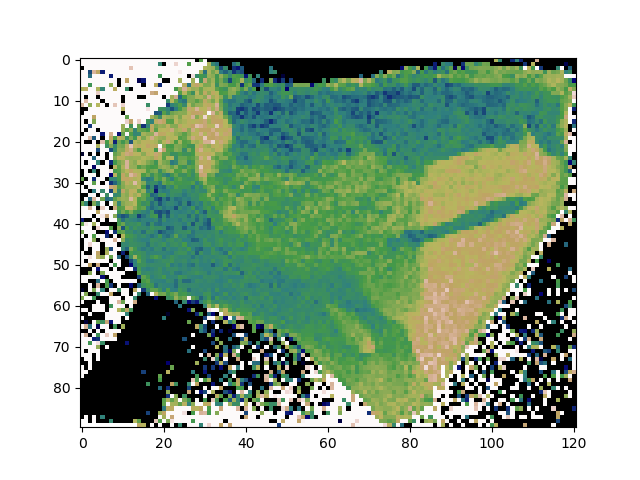

In [18]:
fig, axes = plt.subplots()
# The angle difference between the two vectors reveals domains
axes.imshow(main_angle_difference, cmap=cm.gist_earth, vmin=88.5, vmax=91.5)

<IPython.core.display.Javascript object>


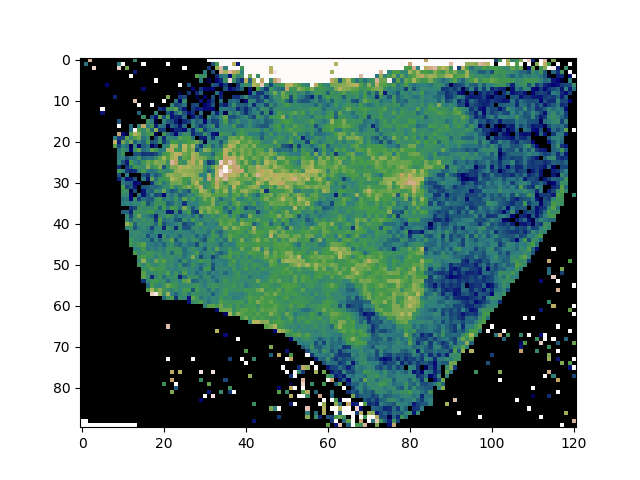

In [19]:
fig, axes = plt.subplots()
# This plot reveals differences in the unit cell volume
axes.imshow(main_volume, cmap=cm.gist_earth, vmin=208, vmax=216)

<IPython.core.display.Javascript object>


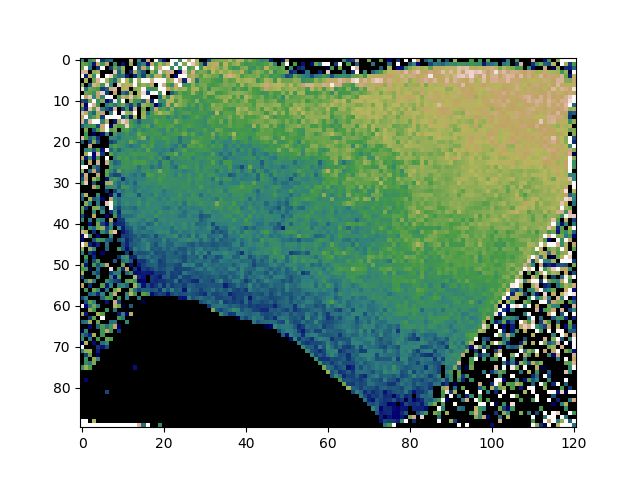

In [20]:
fig, axes = plt.subplots()
# Shifts of the zero point might reveal electromagnetic fields under some conditions
axes.imshow(main_zeros[:, :, 0], cmap=cm.gist_earth, vmin=72.2, vmax=72.8)

<IPython.core.display.Javascript object>


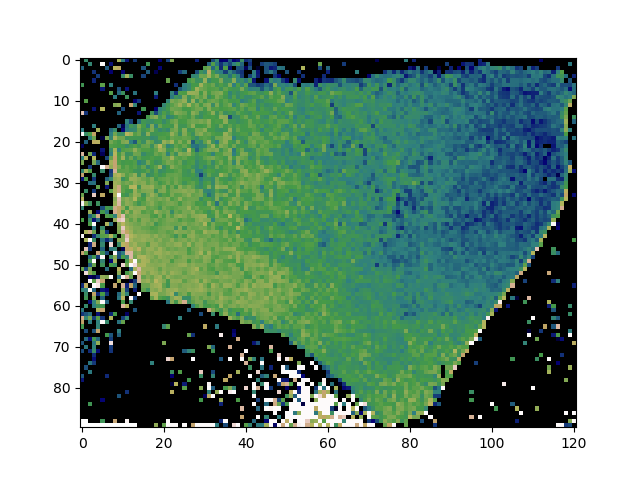

In [21]:
fig, axes = plt.subplots()
axes.imshow(main_zeros[:, :, 1], cmap=cm.gist_earth, vmin=71.3, vmax=71.9)